#### HAVOK analysis of the Lorenz system

**Converted by ChatGPT from the original MATLAB demo (Brunton et al., 2016).**

https://arxiv.org/abs/1608.05306

1. Integrate the Lorenz equations

2. Delay embedding & SVD

3. Build the HAVOK linear model

4. Simulate the forced linear system

5. Quick sanity plots

6. Forcing statistics

7. U-modes

8. Detect forcing and paint attractor

9. Time-series colouring

10. Integer-valued test model

11. Skeleton plot


#### Helper functions

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import svd
from scipy.signal import StateSpace, lsim

plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

def lorenz(t, state, sigma=10.0, beta=8.0/3.0, rho=28.0):
    x, y, z = state
    return [sigma*(y - x),
            x*(rho - z) - y,
            x*y - beta*z]

def optimal_svht_coef(beta):
    # cubic fit for 0<beta<=1  (Gavish–Donoho 2014)
    return 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43

def build_hankel(series, stack_max):
    N = len(series)
    return np.stack([series[k:N-stack_max+k] for k in range(stack_max)])

def central_finite_diff(V, dt):
    dV = np.zeros_like(V)
    dV[2:-2] = (-V[4:] + 8*V[3:-1] - 8*V[1:-3] + V[:-4])/(12*dt)
    dV[0]  = (V[1]-V[0])/dt
    dV[1]  = (V[2]-V[0])/(2*dt)
    dV[-2] = (V[-1]-V[-3])/(2*dt)
    dV[-1] = (V[-1]-V[-2])/dt
    return dV

def pool_data(X):
    n_samples = X.shape[0]
    return np.hstack([np.ones((n_samples,1)), X])

def sparsify_dynamics(Theta, dx, lam=0.0, n_iter=10):
    if dx.ndim == 1:
        dx = dx[:, None]
    Xi = np.linalg.lstsq(Theta, dx, rcond=None)[0]
    for _ in range(n_iter):
        small = np.abs(Xi) < lam
        Xi[small] = 0.0
        for j in range(Xi.shape[1]):
            big = ~small[:, j]
            if not np.any(big):
                continue
            Xi[big, j] = np.linalg.lstsq(Theta[:, big], dx[:, j], rcond=None)[0]
    return Xi.squeeze()


#### 1 – Integrate the Lorenz system

In [3]:
# Parameters
sigma, beta, rho = 10.0, 8.0/3.0, 28.0
x0 = np.array([-8.0, 8.0, 27.0])
dt = 1e-3
tspan = np.arange(dt, 200.0+dt, dt)

# Integrate
sol = solve_ivp(lambda t, x: lorenz(t, x, sigma, beta, rho),
                (tspan[0], tspan[-1]), x0,
                t_eval=tspan, rtol=1e-12, atol=1e-12*np.ones(3))
xdat = sol.y.T  # shape (N,3)

print(f'Done: {xdat.shape[0]} time steps')


Done: 200000 time steps


#### 2 – Delay embedding & SVD

In [4]:
stack_max = 100
H = build_hankel(xdat[:,0], stack_max)
U, S, Vh = svd(H, full_matrices=False)
beta_ratio = H.shape[0]/H.shape[1]
thresh = optimal_svht_coef(beta_ratio) * np.median(S)
r = min(int((S>thresh).sum()), 15)
print(f'Chosen rank r = {r}')

V = Vh.T[:, :r]
dV = central_finite_diff(V, dt)

# Align lengths
x = V[2:-2]
dx = dV[2:-2]


Chosen rank r = 15


#### 3 – Build the HAVOK linear model

In [5]:
Theta = pool_data(x)
norm_theta = np.linalg.norm(Theta, axis=0)
Theta_n = Theta / norm_theta

Xi = np.zeros((Theta.shape[1], r-1))
for k in range(r-1):
    Xi[:, k] = sparsify_dynamics(Theta_n, dx[:, k], lam=0.0)
Xi /= norm_theta[:, None]

Atemp = Xi[1:r+1, :r-1].T
B = Atemp[:, -1][:, None]
A = Atemp[:, :-1]

print('A shape:', A.shape, '  B shape:', B.shape)


A shape: (14, 14)   B shape: (14, 1)


#### 4 – Simulate the forced linear system

In [6]:
sys = StateSpace(A, B, np.eye(r-1), np.zeros((r-1,1)))
L = np.arange(50_000)
_, y, _ = lsim(sys, U=V[L,-1], T=dt*L, X0=V[0, :r-1])


#### 5 – Quick sanity plots

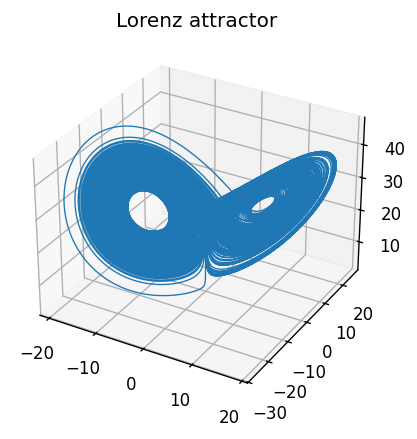

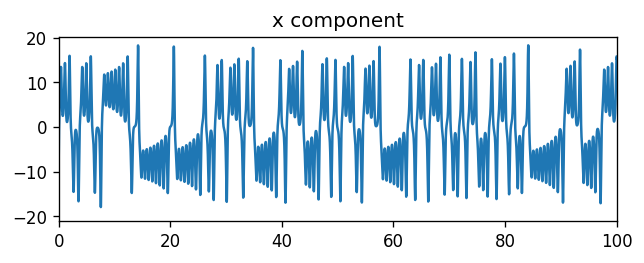

In [7]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*xdat[:200000].T, lw=0.8)
ax.set_title('Lorenz attractor'); plt.show()

plt.figure(figsize=(6,2))
plt.plot(tspan, xdat[:,0])
plt.xlim(0,100); plt.title('x component'); plt.show()


#### 6 - Forcing statistics

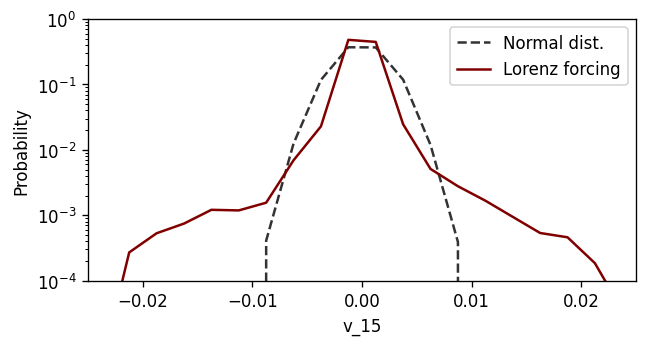

In [8]:
# --- Part 6: forcing statistics ------------------------------------------
plt.figure(figsize=(5.5, 3))
Vtest = np.std(V[:, -1]) * np.random.randn(200_000)

h,  bins  = np.histogram(V[:, -1] - V[:, -1].mean(),
                         bins=np.arange(-0.03, 0.0301, 0.0025))
hn, bins2 = np.histogram(Vtest - Vtest.mean(),
                         bins=np.arange(-0.02, 0.0201, 0.0025))
bc  = (bins[:-1]  + bins[1:])  / 2
bc2 = (bins2[:-1] + bins2[1:]) / 2

plt.semilogy(bc2, hn/hn.sum(),  '--', color=[.2, .2, .2],
             lw=1.5, label='Normal dist.')
plt.semilogy(bc,  h/h.sum(),    color=[.5, 0, 0],
             lw=1.5, label='Lorenz forcing')
plt.xlabel(f'v_{r}'); plt.ylabel('Probability')
plt.xlim(-0.025, 0.025); plt.ylim(1e-4, 1)
plt.legend(); plt.tight_layout(); plt.show()


#### 7 - U-modes

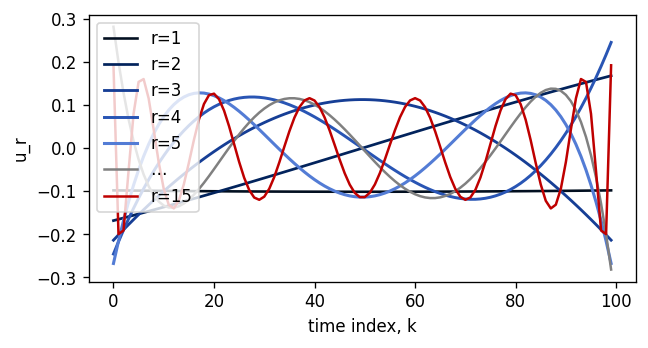

In [14]:
# --- Part 7: U-modes ------------------------------------------------------
plt.figure(figsize=(5.5, 3))
CC = np.array([[2, 15, 32], [2, 35, 92], [22, 62, 149],
               [41, 85, 180], [83, 124, 213], [112, 148, 223],
               [114, 155, 215]]) / 255.0

for k in range(5):                                # r=1…5 — цветная «радуга»
    plt.plot(U[:, k], lw=1.5 + 2*(k+1)/30, color=CC[k])
if U.shape[1] >= 6:                               # r = 6 — серый
    plt.plot(U[:, 5], color=[.5, .5, .5], lw=1.5)
if U.shape[1] >= 15:                              # r = 15 — бордовый
    plt.plot(U[:, 14], color=[.75, 0, 0],   lw=1.5)

plt.xlabel('time index, k'); plt.ylabel('u_r')
plt.legend(['r=1','r=2','r=3','r=4','r=5','…','r=15'], loc='upper left')
plt.tight_layout(); plt.show()


#### 8 - Detect forcing and paint attractor

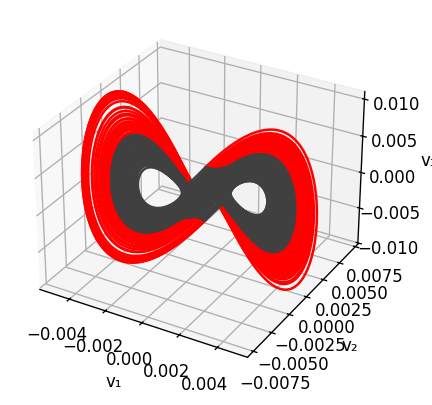

In [10]:
# --- Part 8: detect forcing and paint attractor ---------------------------
inds = (V[:, r-1]**2 > 4e-6)           # r-й (последний) координат > threshold
L_full = np.arange(len(V))

startvals, endvals = [], []
start = 1683                           # как в MATLAB-коде
numhits = 100
for _ in range(numhits):
    startvals.append(start)
    endmax = start + 500
    interval = np.arange(start, endmax + 1)
    hits = interval[inds[interval]]
    endval = hits[-1]                  # последний индекс, пока активен forcing
    endvals.append(endval)
    # найдём следующий блок активности
    next_hits = np.where(inds[endval + 1:])[0]
    start = endval + 1 + next_hits[0]

# 3-D траектория: красным — «forcing active», серым — «inactive»
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
for s, e in zip(startvals, endvals):
    ax.plot(V[s:e+1, 0], V[s:e+1, 1], V[s:e+1, 2], 'r', lw=1.5)
for e_prev, s_next in zip(endvals[:-1], startvals[1:]):
    ax.plot(V[e_prev:s_next+1, 0], V[e_prev:s_next+1, 1], V[e_prev:s_next+1, 2],
            color=[.25, .25, .25], lw=1.5)
ax.set_xlabel('v₁'); ax.set_ylabel('v₂'); ax.set_zlabel('v₃')
plt.show()


#### 9 - Time-series colouring

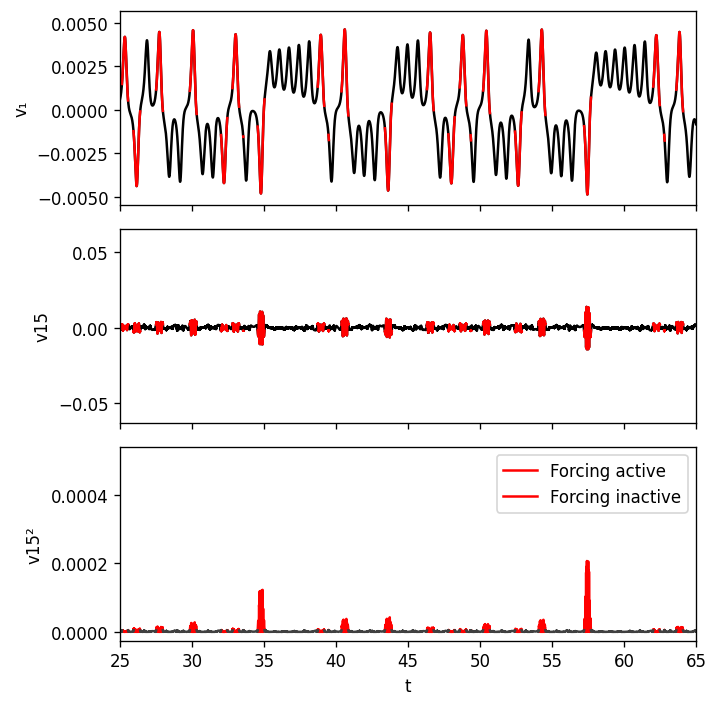

In [11]:
# --- Part 9: time-series colouring ---------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# v1
ax1.plot(tspan[:len(V)], V[:, 0], 'k')
for s, e in zip(startvals, endvals):
    ax1.plot(tspan[s:e+1], V[s:e+1, 0], 'r', lw=1.5)
ax1.set_ylabel('v₁')

# v_r
ax2.plot(tspan[:len(V)], V[:, r-1], 'k')
for s, e in zip(startvals, endvals):
    ax2.plot(tspan[s:e+1], V[s:e+1, r-1], 'r', lw=1.5)
ax2.set_ylabel(f'v{r}')

# v_r²
for s, e in zip(startvals, endvals):
    ax3.plot(tspan[s:e+1], V[s:e+1, r-1]**2, 'r', lw=1.5)
for e_prev, s_next in zip(endvals[:-1], startvals[1:]):
    ax3.plot(tspan[e_prev:s_next+1],
             V[e_prev:s_next+1, r-1]**2, color=[.25, .25, .25], lw=1.5)
ax3.set_xlabel('t'); ax3.set_ylabel(f'v{r}²')
ax3.legend(['Forcing active', 'Forcing inactive'])
ax3.set_xlim(25, 65)
plt.tight_layout(); plt.show()


#### 10 - Integer-valued test model

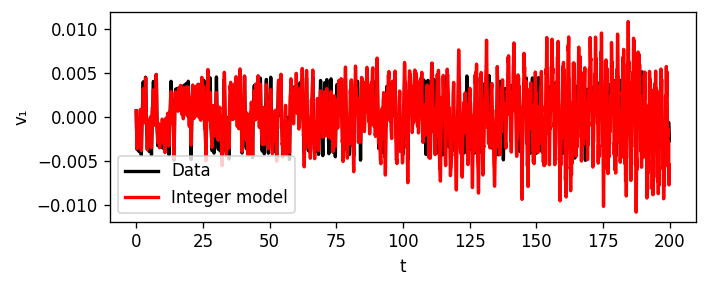

In [12]:
# --- Part 10: integer-valued test model ----------------------------------
A_int = np.zeros((14, 14))
A_int += np.diag([-5, -10, -15, -20, 25, -30, -35, -40,
                  45, -50, -55, 60, -65], 1)
A_int += np.diag([5, 10, 15, 20, -25, 30, 35, 40,
                  -45, 50, 55, -60, 65], -1)
B_int = np.zeros((14, 1)); B_int[-1] = -70

sys_int = StateSpace(A_int, B_int, np.eye(14), np.zeros((14, 1)))
_, y_int, _ = lsim(sys_int, U=V[:, r-1], T=tspan[:len(V)], X0=V[0, :14])

plt.figure(figsize=(6, 2.5))
plt.plot(tspan[:199900], V[:199900, 0], 'k', lw=2, label='Data')
plt.plot(tspan[:199900], y_int[:199900, 0], 'r', lw=2, label='Integer model')
plt.legend(); plt.xlabel('t'); plt.ylabel('v₁')
plt.tight_layout(); plt.show()


#### 11 - Skeleton plot

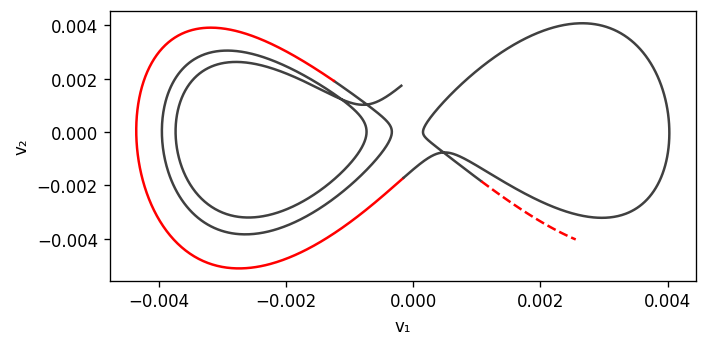

In [13]:
# --- Part 11: skeleton plot ----------------------------------------------
k = 27  # номер интересующего «переключения» (как в статье)

L0 = slice(endvals[k-2], startvals[k-1])
L1 = slice(startvals[k-1], endvals[k-1])
L2 = slice(endvals[k-1], startvals[k])
L3 = slice(startvals[k], startvals[k] + 100)

plt.figure(figsize=(6, 3))
plt.plot(V[L0, 0], V[L0, 1], color=[.25, .25, .25], lw=1.5)
plt.plot(V[L1, 0], V[L1, 1], 'r', lw=1.5)
plt.plot(V[L2, 0], V[L2, 1], color=[.25, .25, .25], lw=1.5)
plt.plot(V[L3, 0], V[L3, 1], 'r--', lw=1.5)
plt.xlabel('v₁'); plt.ylabel('v₂'); plt.tight_layout(); plt.show()
